# Test trained model(s)

In [8]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher Chan        #
#Version: 0.4.5                      #
#Date: 2022-08-02                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()
Five_UNet = Five_UNet()

Training on device cpu.


In [9]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
#for x, y in zip(Test.png_dir, Test.lbl_dir):
#    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 435 and labels pair: 435 :


<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

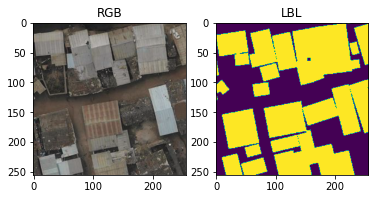

In [12]:
# plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [13]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_057458.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.0680638951043875e-07, Maximum: 0.005735916551202536, Mean: 0.000542866881005466, St dev: 0.000979085685685277
True Positive = 6198, True Negative = 20910 False Negative = 32330, False Positive = 6098
Precision = 0.5040663480758667, Recall = 0.1608700156211853, Specificity = 0.774215042591095 Overall Accuracy = 0.41363525390625, Intersection-over-Union = 0.13888764381408691, Dice-Score = 0.24390052258968353


Text(0.5, 1.0, 'Binary Segmentation')

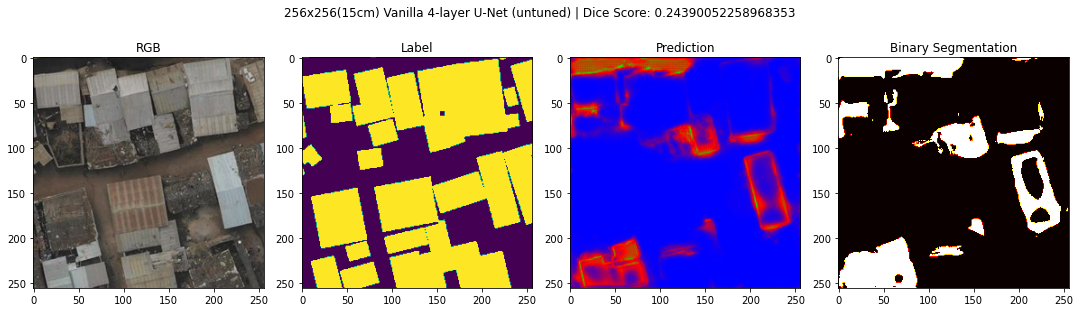

In [14]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)
   
    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Vanilla Five layer U-Net Baseline

In [15]:
weights_5UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_Five-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_028818.pth"))
weights_5UNet = torch.load(weights_5UNet, map_location = device)
Five_UNet.load_state_dict(weights_5UNet["Model:"])
Five_UNet.to(device = device)

print(sum(p.numel() for p in Five_UNet.parameters() if p.requires_grad == True))

31100513


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.077358800534057e-07, Maximum: 0.005643144715577364, Mean: 0.00039840544923208654, St dev: 0.0008184450562112033
True Positive = 7148, True Negative = 25363 False Negative = 31380, False Positive = 1645
Precision = 0.8129193782806396, Recall = 0.18552741408348083, Specificity = 0.9390920996665955 Overall Accuracy = 0.4960784912109375, Intersection-over-Union = 0.17793044447898865, Dice-Score = 0.3021068871021271


Text(0.5, 1.0, 'Binary Segmentation')

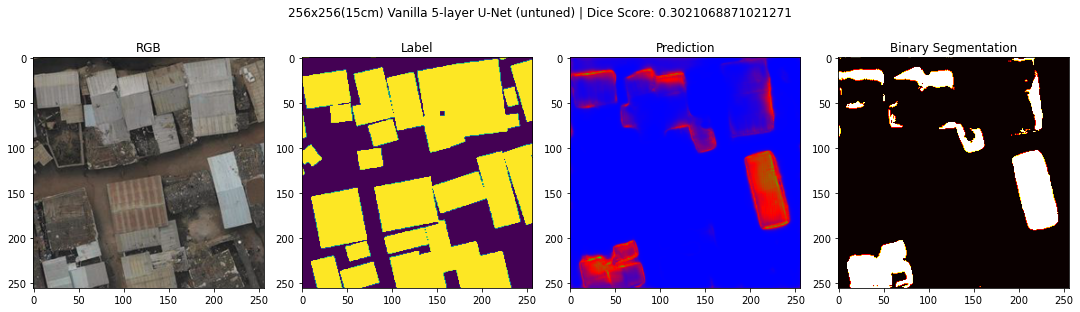

In [16]:
Five_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Five_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)
   
    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 5-layer U-Net (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet (transfer-untrained)

In [17]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 6.0642595939732586e-18, Maximum: 1.0, Mean: 0.24096599221229553, St dev: 0.4208638370037079
True Positive = 17590, True Negative = 25945 False Negative = 20938, False Positive = 1063
Precision = 0.9430118203163147, Recall = 0.45655107498168945, Specificity = 0.9606412649154663 Overall Accuracy = 0.6642913818359375, Intersection-over-Union = 0.44429290294647217, Dice-Score = 0.6152393221855164


Text(0.5, 1.0, 'Binary Segmentation')

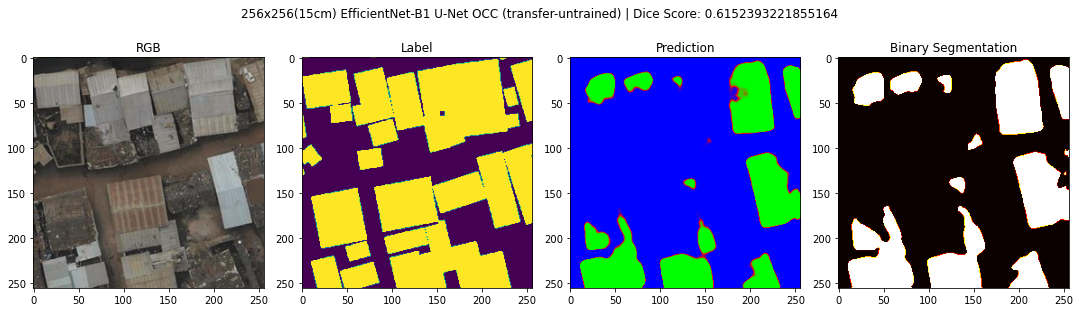

In [18]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet (transfer-trained-untuned)

In [19]:
qubvelTRANSTRAIN_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvelTRANSTRAIN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)_iter_082697.pth"))
qubvelTRANSTRAIN_weights = torch.load(qubvelTRANSTRAIN_weights, map_location = device)
qubvelTRANSTRAIN_UNet.load_state_dict(qubvelTRANSTRAIN_weights["Model:"])
qubvelTRANSTRAIN_UNet.to(device = device)

print(sum(p.numel() for p in qubvelTRANSTRAIN_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 4.2225241969617855e-08, Maximum: 0.0077025690115988255, Mean: 0.0009916754206642509, St dev: 0.0012476581614464521
True Positive = 17350, True Negative = 20321 False Negative = 21178, False Positive = 6687
Precision = 0.7218039035797119, Recall = 0.45032185316085815, Specificity = 0.7524067163467407 Overall Accuracy = 0.5748138427734375, Intersection-over-Union = 0.3837222158908844, Dice-Score = 0.5546231865882874


Text(0.5, 1.0, 'Binary Segmentation')

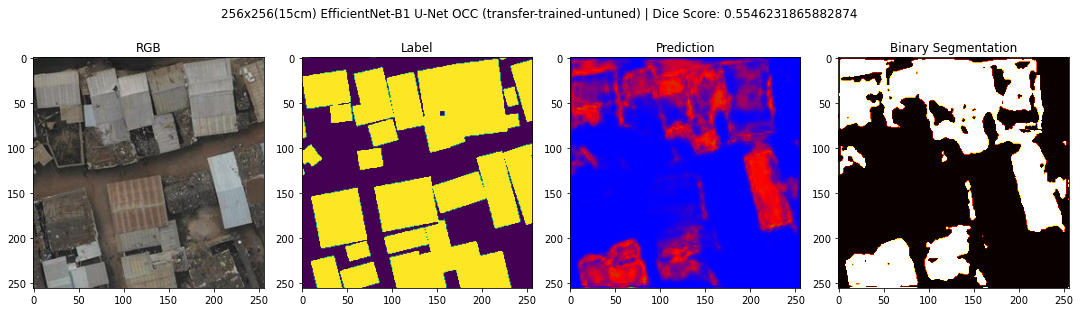

In [20]:
qubvelTRANSTRAIN_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelTRANSTRAIN_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet-B1 U-Net OCC (transfer-trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [21]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB1-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_023448.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 6.341408465004861e-08, Maximum: 0.004251556005328894, Mean: 0.0003260973608121276, St dev: 0.0007759435684420168
True Positive = 3514, True Negative = 24228 False Negative = 35014, False Positive = 2780
Precision = 0.5583094954490662, Recall = 0.091206394135952, Specificity = 0.8970675468444824 Overall Accuracy = 0.423309326171875, Intersection-over-Union = 0.08506827056407928, Dice-Score = 0.15679800510406494


Text(0.5, 1.0, 'Binary Segmentation')

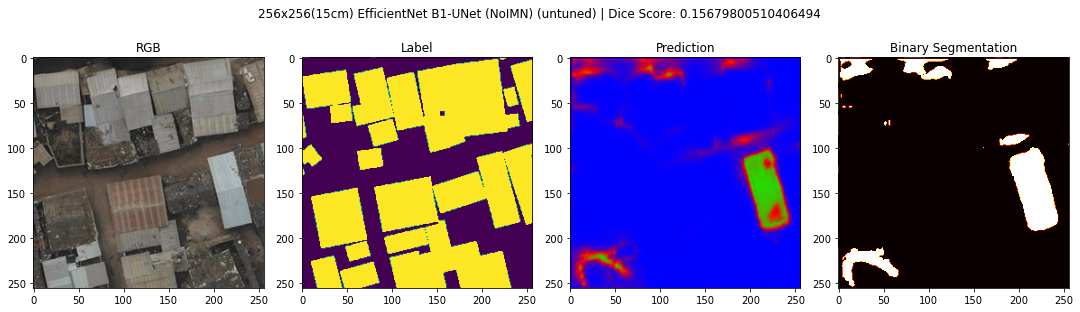

In [22]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))


# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet (NoIMN) (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [23]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_064618.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.0649653603422848e-08, Maximum: 0.008303126320242882, Mean: 7.864189683459699e-05, St dev: 0.0002801491937134415
True Positive = 827, True Negative = 26717 False Negative = 37701, False Positive = 291
Precision = 0.7397137880325317, Recall = 0.021464908495545387, Specificity = 0.9892253875732422 Overall Accuracy = 0.4202880859375, Intersection-over-Union = 0.021304000169038773, Dice-Score = 0.0417192168533802


Text(0.5, 1.0, 'Binary Segmentation')

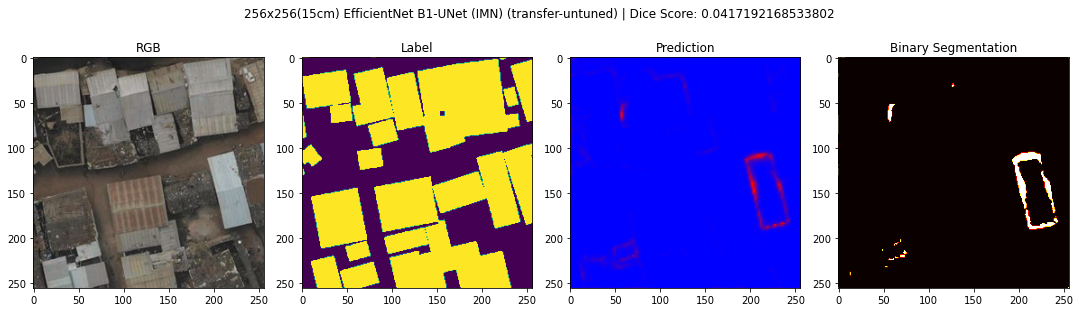

In [24]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet (IMN) (transfer-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B2-UNet (NoIMN) Baseline

In [25]:
EB2_UNet_NoIMN = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB2_NoIMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB2-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_064618.pth"))
EB2_NoIMN_weights = torch.load(EB2_NoIMN_weights, map_location = device)
EB2_UNet_NoIMN.load_state_dict(EB2_NoIMN_weights["Model:"])
EB2_UNet_NoIMN.to(device = device)

print(sum(p.numel() for p in EB2_UNet_NoIMN.parameters() if p.requires_grad == True))

8211283


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.670992564432709e-09, Maximum: 0.014738802798092365, Mean: 0.00023861652880441397, St dev: 0.0005783147062174976
True Positive = 2731, True Negative = 24897 False Negative = 35797, False Positive = 2111
Precision = 0.5640231370925903, Recall = 0.07088351249694824, Specificity = 0.9218379855155945 Overall Accuracy = 0.42156982421875, Intersection-over-Union = 0.06720145791769028, Dice-Score = 0.12593959271907806


Text(0.5, 1.0, 'Binary Segmentation')

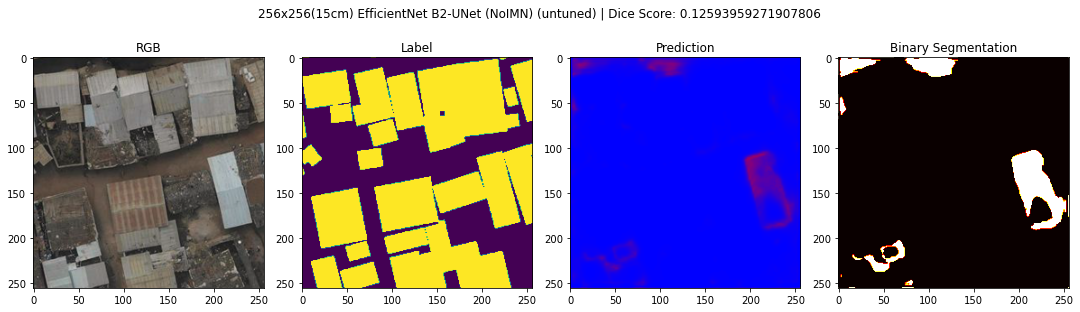

In [26]:
EB2_UNet_NoIMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB2_UNet_NoIMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B2-UNet (NoIMN) (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B2-UNet (IMN) Baseline

In [27]:
EB2_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB2_IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB2-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_086098.pth"))
EB2_IMN_weights = torch.load(EB2_IMN_weights, map_location = device)
EB2_UNet_IMN.load_state_dict(EB2_IMN_weights["Model:"])
EB2_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB2_UNet_IMN.parameters() if p.requires_grad == True))

8211283


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.698804817986456e-08, Maximum: 0.006853082217276096, Mean: 6.213455344550312e-05, St dev: 0.00019815488485619426
True Positive = 601, True Negative = 26915 False Negative = 37927, False Positive = 93
Precision = 0.8659942150115967, Recall = 0.015599044971168041, Specificity = 0.9965565800666809 Overall Accuracy = 0.41986083984375, Intersection-over-Union = 0.015561481937766075, Dice-Score = 0.0306460652500391


Text(0.5, 1.0, 'Binary Segmentation')

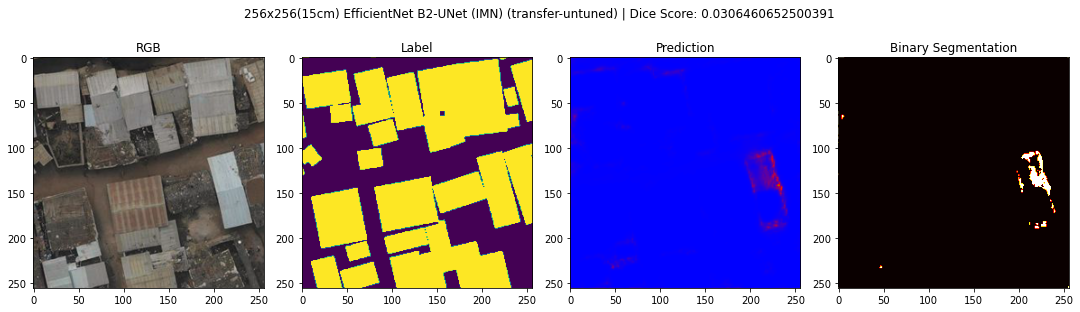

In [28]:
EB2_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB2_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B2-UNet (IMN) (transfer-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')